<a href="https://colab.research.google.com/github/Kanaieu/deteksi-7-bunga-cnn/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [7 Spesies Bunga](https://www.kaggle.com/datasets/nadyana/flowers/data)
- **Nama:** Muhammad Tsaqiif Ash-Shiddiq
- **Email:** muhammadtsaqiif.ash@gmail.com
- **ID Dicoding:** muhammadtsaqiifash

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflowjs

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadtsaqiifa","key":"1572ef8a163b81d1b96bbe808a6d053f"}'}

In [4]:
!rm -rf flowers/

In [7]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d nadyana/flowers
!unzip flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/lotus/lotusnvevin.jpg  
  inflating: flowers/lotus/louts-flower-pond-close-up-petals-stamin-lotus-lily-144696984.jpg  
  inflating: flowers/lotus/macro-lotus-flower-13214393.jpg  
  inflating: flowers/lotus/macro-pink-lotus-flower-macro-pink-lotus-flower-close-up-pink-lotus-flower-raining-sunlight-morning-159065830.jpg  
  inflating: flowers/lotus/maxresdefault1.jpg  
  inflating: flowers/lotus/micro_-shot_-of_-a_-white_-lotus_-flower_-micro_-shot_-of_-a_-white_-lotus_-flower_-with_-green_-159427226.jpg  
  inflating: flowers/lotus/national_flower_inner.jpg  
  inflating: flowers/lotus/ndsfgiw.png  
  inflating: flowers/lotus/nelumbo-nucifera-flower-also-known-as-indian-lotus-sacred-lotus-bean-india-egyptian-bean-simply-lotus-nelumbo-nucifera-143764558.jpg  
  inflating: flowers/lotus/nelumbo_2.jpg  
  inflating: flowers/lotus/nlevnwoejr.jpg  
  inflating: flowers/lotus/p9ihfe5f.png  
  inflating: flowers/lotus/pex

**Plot gambar sampel untuk semua kelas**

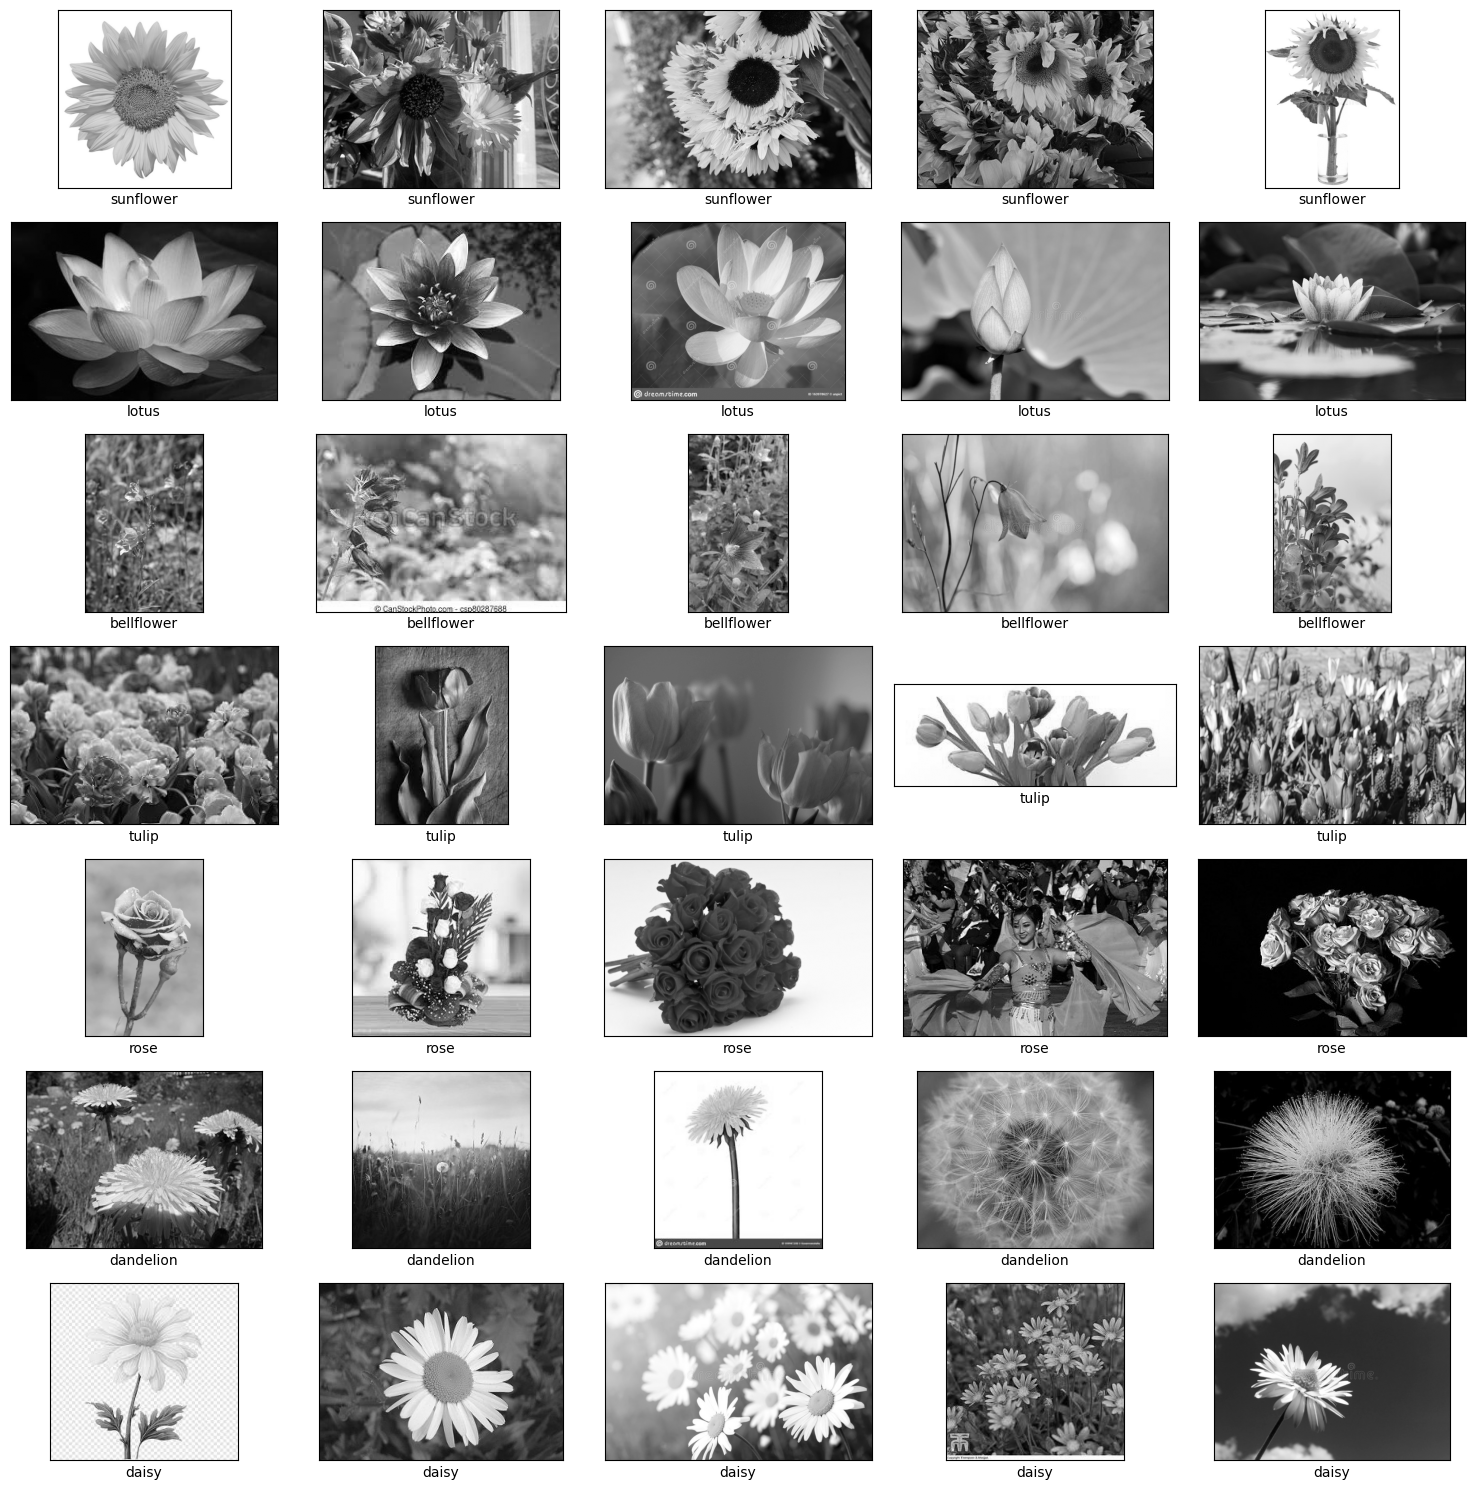

In [9]:
lung_image = {}

path = "flowers/"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot distribusi gambar di seluruh kelas**

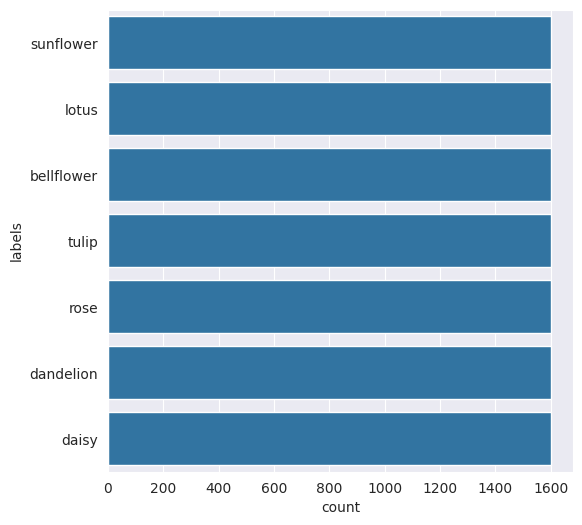

In [10]:
lung_path = "flowers/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [6]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'flowers/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

In [ ]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Menggunakan Stratify agar penyebaran seimbang**

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

In [ ]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))

In [ ]:
datasource_path = "flowers/"
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

#### Image Data Generator

In [ ]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_bellflower = os.path.join(TRAIN_DIR, 'bellflower')
train_daisy = os.path.join(TRAIN_DIR, 'daisy')
train_dandelion = os.path.join(TRAIN_DIR, 'dandelion')
train_lotus = os.path.join(TRAIN_DIR, 'lotus')
train_rose = os.path.join(TRAIN_DIR, 'rose')
train_sunflower = os.path.join(TRAIN_DIR, 'sunflower')
train_tulips = os.path.join(TRAIN_DIR, 'tulips')

test_bellflower = os.path.join(TEST_DIR, 'bellflower')
test_daisy = os.path.join(TEST_DIR, 'daisy')
test_dandelion = os.path.join(TEST_DIR, 'dandelion')
test_lotus = os.path.join(TEST_DIR, 'lotus')
test_rose = os.path.join(TEST_DIR, 'rose')
test_sunflower = os.path.join(TEST_DIR, 'sunflower')
test_tulips = os.path.join(TEST_DIR, 'tulips')

print("Total number of bellflower images in training set: ", len(os.listdir(train_bellflower)))
print("Total number of daisy images in training set: ", len(os.listdir(train_daisy)))
print("Total number of dandelion images in training set: ", len(os.listdir(train_dandelion)))
print("Total number of lotus images in training set: ", len(os.listdir(train_lotus)))
print("Total number of rose images in training set: ", len(os.listdir(train_rose)))
print("Total number of sunflower images in training set: ", len(os.listdir(train_sunflower)))
print("Total number of tulips images in training set: ", len(os.listdir(train_tulips)))

print("Total number of bellflower images in test set: ", len(os.listdir(test_bellflower)))
print("Total number of daisy images in test set: ", len(os.listdir(test_daisy)))
print("Total number of dandelion images in test set: ", len(os.listdir(test_dandelion)))
print("Total number of lotus images in test set: ", len(os.listdir(test_lotus)))
print("Total number of rose images in test set: ", len(os.listdir(test_rose)))
print("Total number of sunflower images in test set: ", len(os.listdir(test_sunflower)))
print("Total number of tulips images in test set: ", len(os.listdir(test_tulips)))

In [ ]:
def resize_with_padding(image, target_height, target_width):
    image = tf.image.resize(image, [target_height, target_width], preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image

def custom_generator(directory, datagen, target_size=(150, 150), batch_size=32, subset=None):
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset=subset
    )

    while True:
        x_batch, y_batch = generator.next()
        x_batch_padded = []
        for image in x_batch:
            image_padded = resize_with_padding(image, target_size[0], target_size[1])
            x_batch_padded.append(image_padded)
        yield (tf.stack(x_batch_padded), y_batch)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = custom_generator(
    TRAIN_DIR,
    datagen,
    target_size=(150, 150),
    batch_size=32,
    subset='training',
    shuffle=True
)

validation_generator = custom_generator(
    TRAIN_DIR,
    datagen,
    target_size=(150, 150),
    batch_size=32,
    subset='validation',
    shuffle=False
)

test_generator = custom_generator(
    TEST_DIR,
    test_datagen,
    target_size=(150, 150),
    batch_size=1,
    subset=None,
    shuffle=False
)

## Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [6]:
model_32 = Sequential([
    # 1st Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(32, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(32, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Dense + Dropout layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(7, activation='softmax')
])

In [ ]:
model_32.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
print(model_32.summary())

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history_32 = model_32.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_reduction_callback]
)

## Evaluasi dan Visualisasi

In [6]:
acc = history_32.history['accuracy']
val_acc = history_32.history['val_accuracy']
loss = history_32.history['loss']
val_loss = history_32.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_1 = model_32.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1),
                  index=["Actual Bellflower", "Actual Daisy", "Actual Dandelion", "Actual Lotus", "Actual Rose", "Actual Sunflower", "Actual Tulips"],
                  columns=["Predicted Bellflower", "Predicted Daisy", "Predicted Dandelion", "Predicted Lotus", "Predicted Rose", "Predicted Sunflower", "Predicted Tulips"])

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_1,
                            target_names=['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulips'],
                            digits=4))

## Konversi Model

**savedmodel**

In [6]:
model_32.save("/content/saved_model")

**TensorFlow Lite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_32)
tflite_model = converter.convert()

with open("/content/tflite/model_32.tflite", "wb") as f:
    f.write(tflite_model)

**TensorFlow.js**

In [ ]:
tfjs.converters.save_keras_model(model_32, "/content/tfjs_model")

## Inference (Optional)

In [6]:
model_path = '/content/saved_model'
model = tf.keras.models.load_model(model_path)

In [ ]:
img_path = 'flowers/bellflower/0.jpg'
img = tf.keras.preprocessing.image.load_img(img_path)
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array_resized = resize_with_padding(img_array, 150, 150)
img_array_resized = img_array_resized / 255.0

img_array_resized = tf.expand_dims(img_array_resized, axis=0)

predictions = model_1.predict(img_array_resized)
print(predictions)